**Chapter 9 – Introduction to Artificial Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 9._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/09_artificial_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/09_artificial_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.5.2:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.5.2")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [6]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [7]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

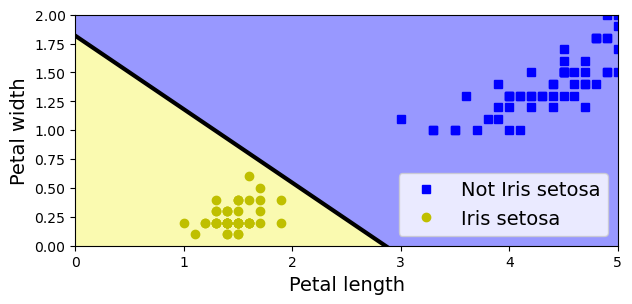

In [8]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

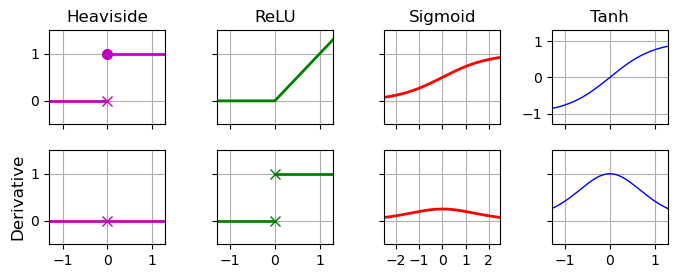

In [9]:
# extra code – this cell generates and saves Figure 9–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

save_fig("activation_functions_plot")
plt.show()

# Building and Training MLPs with Scikit-Learn
## Regression MLPs

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    housing.data, housing.target, random_state=42)

In [12]:
mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], early_stopping=True,
                       verbose=True, random_state=42)

In [13]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.85190332
Validation score: 0.534299
Iteration 2, loss = 0.28288639
Validation score: 0.651094
Iteration 3, loss = 0.22884372
Validation score: 0.699782
Iteration 4, loss = 0.20746145
Validation score: 0.720468
Iteration 5, loss = 0.19649383
Validation score: 0.724839
Iteration 6, loss = 0.18928708
Validation score: 0.740084
Iteration 7, loss = 0.18132029
Validation score: 0.747406
Iteration 8, loss = 0.17556450
Validation score: 0.753945
Iteration 9, loss = 0.17190651
Validation score: 0.760500
Iteration 10, loss = 0.16687650
Validation score: 0.759213
Iteration 11, loss = 0.16329479
Validation score: 0.761907
Iteration 12, loss = 0.16054473
Validation score: 0.768950
Iteration 13, loss = 0.15690181
Validation score: 0.762699
Iteration 14, loss = 0.15630644
Validation score: 0.766003
Iteration 15, loss = 0.15712517
Validation score: 0.778464
Iteration 16, loss = 0.15155981
Validation score: 0.774237
Iteration 17, loss = 0.14957641
Validation score: 0.778361
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [14]:
mlp_reg.best_validation_score_

0.791536125425778

In [15]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [16]:
rmse

0.5327699946812925

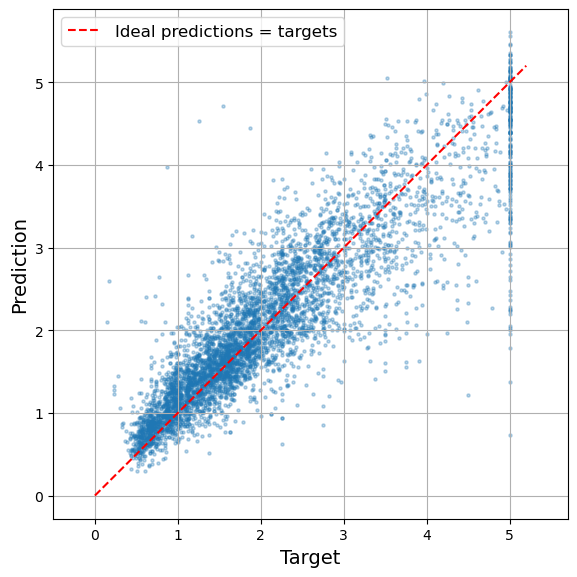

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0, 5.2], color='red', linestyle='--',
         label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
save_fig("predictions_vs_targets_plot")

plt.show()

## Classification MLPs

In [18]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
targets = fashion_mnist.target.astype(int)

In [22]:
X_train, y_train = fashion_mnist.data[:60_000], targets[:60_000]
X_test, y_test = fashion_mnist.data[60_000:], targets[60_000:]

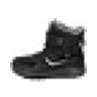

In [23]:
X_sample = X_train[0].reshape(28, 28)  # first image in the training set
plt.figure(figsize=(1,1))  # extra code – reduce the figure size
plt.imshow(X_sample, cmap="binary")
plt.axis('off')  # extra code – remove the axis
plt.show()

In [24]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [25]:
class_names[y_train[0]]

'Ankle boot'

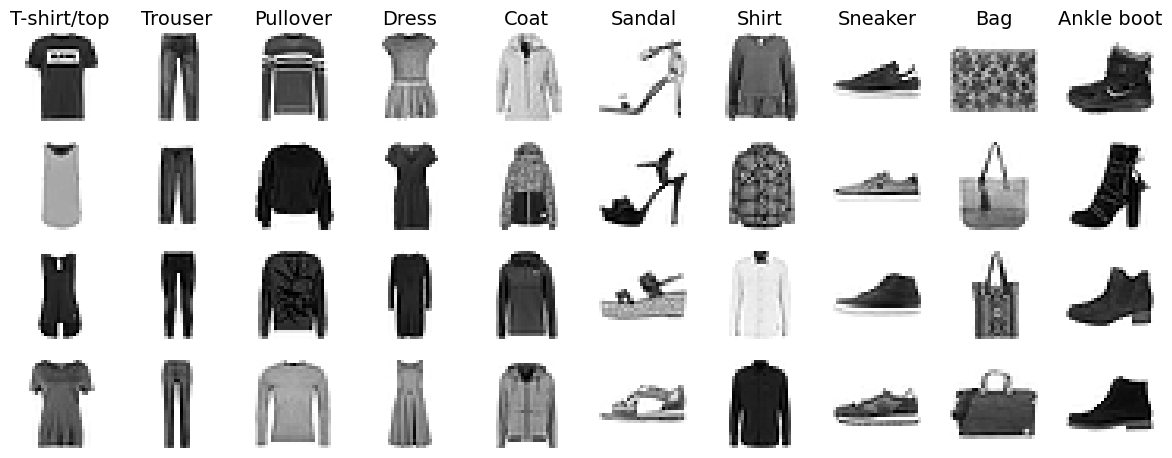

In [26]:
# extra code – this cell generates and saves Figure 9–10
n_rows = 4
plt.figure(figsize=(12, n_rows * 1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 * row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_plot")
plt.show()

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 100], verbose=True,
                        early_stopping=True, random_state=42)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.57483807
Validation score: 0.849333
Iteration 2, loss = 0.39938584
Validation score: 0.856833
Iteration 3, loss = 0.35435272
Validation score: 0.869333
Iteration 4, loss = 0.32570927
Validation score: 0.863833
Iteration 5, loss = 0.30588352
Validation score: 0.874167
Iteration 6, loss = 0.29053832
Validation score: 0.874000
Iteration 7, loss = 0.27455976
Validation score: 0.879333
Iteration 8, loss = 0.26407281
Validation score: 0.878500
Iteration 9, loss = 0.25317835
Validation score: 0.882167
Iteration 10, loss = 0.24414312
Validation score: 0.892833
Iteration 11, loss = 0.23601645
Validation score: 0.890000
Iteration 12, loss = 0.23008384
Validation score: 0.887333
Iteration 13, loss = 0.22123722
Validation score: 0.885167
Iteration 14, loss = 0.21190658
Validation score: 0.879333
Iteration 15, loss = 0.20617121
Validation score: 0.892667
Iteration 16, loss = 0.19935674
Validation score: 0.891667
Iteration 17, loss = 0.19323595
Validation score: 0.891667
Iterat

In [28]:
accuracy

0.8917

In [29]:
mlp_clf.best_validation_score_

0.8955

In [30]:
X_new = X_test[:15]  # let's pretend these are 15 new images
mlp_clf.predict(X_new)

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4])

In [31]:
y_test[:15]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4])

In [32]:
y_proba = mlp_clf.predict_proba(X_new)
y_proba[12]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [30]:
y_proba = mlp_clf.predict_proba(X_test)
(y_proba.max(axis=1) < 0.999).sum()

46

In [31]:
y_proba.max(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [32]:
y_proba = mlp_clf.predict_proba(X_test)
sum(y_proba.max(axis=1) < 0.99)

31

# Exercise solutions

## Exercises 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 9-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## Exercise 10.

*Exercise: Train a deep MLP on the CoverType dataset (you can load it using `sklearn.datasets.fetch_covtype()`). See if you can get over 93% accuracy on the test set by fine-tuning the hyperparameters, manually and/or using `RandomizedSearchCV`.*

In [33]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()
X_train, X_test, y_train, y_test = train_test_split(
    covtype.data, covtype.target, random_state=42)

In [34]:
mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 100, 50], early_stopping=True,
                        verbose=True, random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.54176112
Validation score: 0.806751
Iteration 2, loss = 0.42014984
Validation score: 0.830847
Iteration 3, loss = 0.36860865
Validation score: 0.853589
Iteration 4, loss = 0.33598244
Validation score: 0.864536
Iteration 5, loss = 0.31272332
Validation score: 0.869768
Iteration 6, loss = 0.29537023
Validation score: 0.884111
Iteration 7, loss = 0.28015485
Validation score: 0.883284
Iteration 8, loss = 0.26937433
Validation score: 0.888126
Iteration 9, loss = 0.26004990
Validation score: 0.893129
Iteration 10, loss = 0.25201742
Validation score: 0.892188
Iteration 11, loss = 0.24352796
Validation score: 0.898476
Iteration 12, loss = 0.23721328
Validation score: 0.901941
Iteration 13, loss = 0.23194199
Validation score: 0.904053
Iteration 14, loss = 0.22549482
Validation score: 0.905567
Iteration 15, loss = 0.22150953
Validation score: 0.907770
Iteration 16, loss = 0.21765983
Validation score: 0.909606
Iteration 17, loss = 0.21269369
Validation score: 0.906462
Iterat

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=[200, 100, 50],
                               random_state=42, verbose=True))])

In [35]:
pipeline.score(X_test, y_test)

0.9344660695476169